In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm
from torch.nn import BCEWithLogitsLoss
import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
tqdm.pandas()
pd.set_option("display.max_colwidth", None)

parquet_file_path = ".\..\data\intermediate_data\sample_dataset.br"
df = pd.read_parquet(parquet_file_path, engine="pyarrow")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14520 entries, 0 to 14519
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       14520 non-null  string
 1   sentiment  14520 non-null  string
dtypes: string(2)
memory usage: 227.0 KB


In [4]:
df.sentiment.value_counts()

sentiment
positive    4840
neutral     4840
negative    4840
Name: count, dtype: Int64

In [5]:
df1 = df[df.sentiment == 'negative'].sample(1000, random_state=42)
df2 = df[df.sentiment == 'neutral'].sample(1000, random_state=42)
df3 = df[df.sentiment == 'positive'].sample(1000, random_state=42)

df = pd.concat([df1, df2, df3], axis=0).reset_index(drop=True)

df

,text,sentiment
0,thank god took him long enough to give up on that psycho,negative
1,modi has build his reputation doctorate fakeology questioning being anti modi doesnt make you anti national has failed all fronts bombing terrorists pakistan with what result lost jawans due failed intelligence period,negative
2,terrorist attacks have been the rise jnk and all other places under modi govt amount chest thumping and propaganda can hide these sad facts thump modi out this time,negative
3,well stay in the uk you greasy ass dirt dauber middle finger we did not ask for anyone s opinion outside of america about the roe versus against wade decision this was a flawed ruling that lasted where are you too long our supreme court is our s not the world s mind yo business enraged face,negative
4,from the same inventors of keep it simple stupid on the mouth out of gratitude comes keep it simple stupid on the mouth of family lost friends that is friends brothers cousins uncles fathers mothers and children if by chance they separated keep it simple stupid each other on the mouth when they meet again,negative
...,...,...
2995,i d probably shag her to be fair,positive
2996,hello it would be really good if i won thanks and much love,positive
2997,ahaha incredible inscription wow thanks for trying,positive
2998,there is something big going on in america and around the world earth is still running though so there is alot of heroes if anything can be done to help it is paradoxing with info making networks and being witness that some kind of deal some kind of unity has to be reached fire dove,positive


In [6]:
X = df["text"].to_frame(name="text")
y = df["sentiment"]

In [7]:
from src.utils.split_data import TrainValidTestSplitter


data_splitter = TrainValidTestSplitter(X, y, test_size=0.3, random_state=42)

train_df, valid_df, test_df = data_splitter.get_dataframes()

In [10]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
        )

        if label:
            return {
                "input_ids": encoding["input_ids"].flatten(),
                "attention_mask": encoding["attention_mask"].flatten(),
                "labels": torch.tensor(label, dtype=torch.float),
            }
        else:
            return {
                "input_ids": encoding["input_ids"].flatten(),
                "attention_mask": encoding["attention_mask"].flatten(),
            }

In [11]:
class CustomBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomBERTClassifier, self).__init__()
        # Loading pre-implemented BERT model
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        # Custom additional layers
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.fc2 = nn.Linear(128, num_classes)  # Add another fully connected layer
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        # BERT model
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Extracting CLS token representation
        cls_output = bert_outputs["last_hidden_state"][:, 0, :]
        # Custom layers
        x = self.fc1(cls_output)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [12]:
model = CustomBERTClassifier(num_classes=3)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [13]:
# One hot encoding
one_hot = OneHotEncoder()
train_data = one_hot.fit_transform(train_df[['target']]).toarray().tolist()
val_data = one_hot.fit_transform(valid_df[['target']]).toarray().tolist()
test_data = one_hot.fit_transform(test_df[['target']]).toarray().tolist()

In [14]:
one_hot.categories_

[array(['negative', 'neutral', 'positive'], dtype=object)]

In [15]:
# Dataset creation and DataLoader
train_texts = train_df['text'].tolist()
val_texts = valid_df['text'].tolist()
test_texts = test_df['text'].tolist()

In [16]:
max_length = 100
train_dataset = TextDataset(train_texts, train_data, tokenizer, max_length)
val_dataset = TextDataset(val_texts, val_data, tokenizer, max_length)
test_dataset = TextDataset(test_texts, test_data, tokenizer, max_length)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [18]:
from sklearn.metrics import accuracy_score

def get_accuracy(predictions, real_values):
    predictions = torch.cat(predictions).cpu()
    real_values = torch.cat(real_values).cpu()

    predictions = torch.argmax(predictions, axis=1).numpy()
    real_values = torch.argmax(real_values, axis=1).numpy()

    return accuracy_score(predictions, real_values)

In [19]:
def train_model(model, train_dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    predictions = []
    real_values = []

    # Initialize tqdm to show progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True)

    for batch_idx, batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        predictions.append(outputs)
        real_values.append(labels)

        # Update progress bar
        loop.set_description("Train")
        loop.set_postfix(loss=loss.item())

        
    accuracy = get_accuracy(predictions, real_values)

    return total_loss / len(train_dataloader), accuracy


In [20]:
def test(model, test_dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    real_values = []

    # Initialize tqdm to show progress bar
    loop = tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=True)

    for batch_idx, batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            
            predictions.append(outputs)
            real_values.append(labels)
    
            # Update progress bar
            loop.set_description("Test")
            loop.set_postfix(loss=loss.item())
            
    accuracy = get_accuracy(predictions, real_values)

    return total_loss / len(test_dataloader), accuracy

In [21]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != "cuda":
    raise Exception("=== GPU not found ===")
device

device(type='cuda')

In [22]:
# Model, optimizer, criterion initialization
optimizer = Adam(model.parameters(), lr=1e-5)
criterion = BCEWithLogitsLoss()
num_epochs = 20

In [23]:
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

consecutive_lower_count = 0
best_val_loss = float('inf')  # Initialize with a high value
best_model_weights = None
best_epoch = None

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch: {epoch+1}/{num_epochs}")

    train_loss, train_accuracy = train_model(
        model, train_loader, optimizer, criterion, device
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Train Loss: {train_loss:.4f}\t\tTrain Accuracy: {train_accuracy:.4f}")

    val_loss, val_accuracy = test(model, val_loader, criterion, device)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Val Loss: {val_loss:.4f}\t\tVal Accuracy: {val_accuracy:.4f}")
    
    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        consecutive_lower_count = 0
        # Save the current best model weights
        best_model_weights = model.state_dict()
        best_epoch = epoch
    else:
        consecutive_lower_count += 1

    if consecutive_lower_count >= 5:
        print("Early stopping: Validation loss hasn't improved for 5 consecutive epochs.")
        break
    
# Load the best model weights back into the model
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)


Epoch: 1/20


Train: 100%|██████████| 263/263 [02:33<00:00,  1.72it/s, loss=0.632]


Train Loss: 0.7164		Train Accuracy: 0.5693


Test: 100%|██████████| 29/29 [00:04<00:00,  6.11it/s, loss=0.844]


Val Loss: 0.6623		Val Accuracy: 0.7400

Epoch: 2/20


Train: 100%|██████████| 263/263 [02:32<00:00,  1.72it/s, loss=0.646]


Train Loss: 0.6219		Train Accuracy: 0.8476


Test: 100%|██████████| 29/29 [00:04<00:00,  6.07it/s, loss=0.733]


Val Loss: 0.6413		Val Accuracy: 0.7844

Epoch: 3/20


Train: 100%|██████████| 263/263 [02:41<00:00,  1.63it/s, loss=0.606]


Train Loss: 0.6043		Train Accuracy: 0.8933


Test: 100%|██████████| 29/29 [00:04<00:00,  6.08it/s, loss=0.733]


Val Loss: 0.6366		Val Accuracy: 0.7978

Epoch: 4/20


Train: 100%|██████████| 263/263 [02:43<00:00,  1.61it/s, loss=0.617]


Train Loss: 0.5938		Train Accuracy: 0.9217


Test: 100%|██████████| 29/29 [00:04<00:00,  6.08it/s, loss=0.787]


Val Loss: 0.6419		Val Accuracy: 0.7889

Epoch: 5/20


Train: 100%|██████████| 263/263 [02:19<00:00,  1.89it/s, loss=0.599]


Train Loss: 0.5890		Train Accuracy: 0.9345


Test: 100%|██████████| 29/29 [00:03<00:00,  9.24it/s, loss=0.733]


Val Loss: 0.6459		Val Accuracy: 0.7711

Epoch: 6/20


Train: 100%|██████████| 263/263 [02:04<00:00,  2.11it/s, loss=0.606]


Train Loss: 0.5862		Train Accuracy: 0.9426


Test: 100%|██████████| 29/29 [00:03<00:00,  8.95it/s, loss=0.734]


Val Loss: 0.6369		Val Accuracy: 0.7933

Epoch: 7/20


Train: 100%|██████████| 263/263 [02:06<00:00,  2.08it/s, loss=0.567]


Train Loss: 0.5846		Train Accuracy: 0.9469


Test: 100%|██████████| 29/29 [00:03<00:00,  9.01it/s, loss=0.742]


Val Loss: 0.6317		Val Accuracy: 0.8133

Epoch: 8/20


Train: 100%|██████████| 263/263 [02:06<00:00,  2.08it/s, loss=0.567]


Train Loss: 0.5844		Train Accuracy: 0.9474


Test: 100%|██████████| 29/29 [00:03<00:00,  8.54it/s, loss=0.733]


Val Loss: 0.6358		Val Accuracy: 0.8044

Epoch: 9/20


Train: 100%|██████████| 263/263 [02:05<00:00,  2.10it/s, loss=0.567]


Train Loss: 0.5845		Train Accuracy: 0.9457


Test: 100%|██████████| 29/29 [00:03<00:00,  8.63it/s, loss=0.733]


Val Loss: 0.6340		Val Accuracy: 0.8044

Epoch: 10/20


Train: 100%|██████████| 263/263 [02:07<00:00,  2.06it/s, loss=0.567]


Train Loss: 0.5803		Train Accuracy: 0.9588


Test: 100%|██████████| 29/29 [00:03<00:00,  8.57it/s, loss=0.733]


Val Loss: 0.6339		Val Accuracy: 0.8111

Epoch: 11/20


Train: 100%|██████████| 263/263 [02:06<00:00,  2.08it/s, loss=0.567]


Train Loss: 0.5784		Train Accuracy: 0.9650


Test: 100%|██████████| 29/29 [00:03<00:00,  8.68it/s, loss=0.741]


Val Loss: 0.6316		Val Accuracy: 0.8111

Epoch: 12/20


Train: 100%|██████████| 263/263 [02:06<00:00,  2.08it/s, loss=0.608]


Train Loss: 0.5807		Train Accuracy: 0.9583


Test: 100%|██████████| 29/29 [00:03<00:00,  8.63it/s, loss=0.9]  


Val Loss: 0.6334		Val Accuracy: 0.8200

Epoch: 13/20


Train: 100%|██████████| 263/263 [02:06<00:00,  2.09it/s, loss=0.567]


Train Loss: 0.5836		Train Accuracy: 0.9493


Test: 100%|██████████| 29/29 [00:03<00:00,  9.09it/s, loss=0.733]


Val Loss: 0.6430		Val Accuracy: 0.7800

Epoch: 14/20


Train: 100%|██████████| 263/263 [02:06<00:00,  2.08it/s, loss=0.606]


Train Loss: 0.5801		Train Accuracy: 0.9593


Test: 100%|██████████| 29/29 [00:03<00:00,  8.65it/s, loss=0.733]


Val Loss: 0.6349		Val Accuracy: 0.8000

Epoch: 15/20


Train: 100%|██████████| 263/263 [02:06<00:00,  2.08it/s, loss=0.567]


Train Loss: 0.5798		Train Accuracy: 0.9602


Test: 100%|██████████| 29/29 [00:03<00:00,  8.69it/s, loss=0.9]  


Val Loss: 0.6373		Val Accuracy: 0.8089

Epoch: 16/20


Train: 100%|██████████| 263/263 [02:06<00:00,  2.08it/s, loss=0.608]


Train Loss: 0.5793		Train Accuracy: 0.9617


Test: 100%|██████████| 29/29 [00:03<00:00,  9.18it/s, loss=0.733]

Val Loss: 0.6344		Val Accuracy: 0.8044
Early stopping: Validation loss hasn't improved for 5 consecutive epochs.


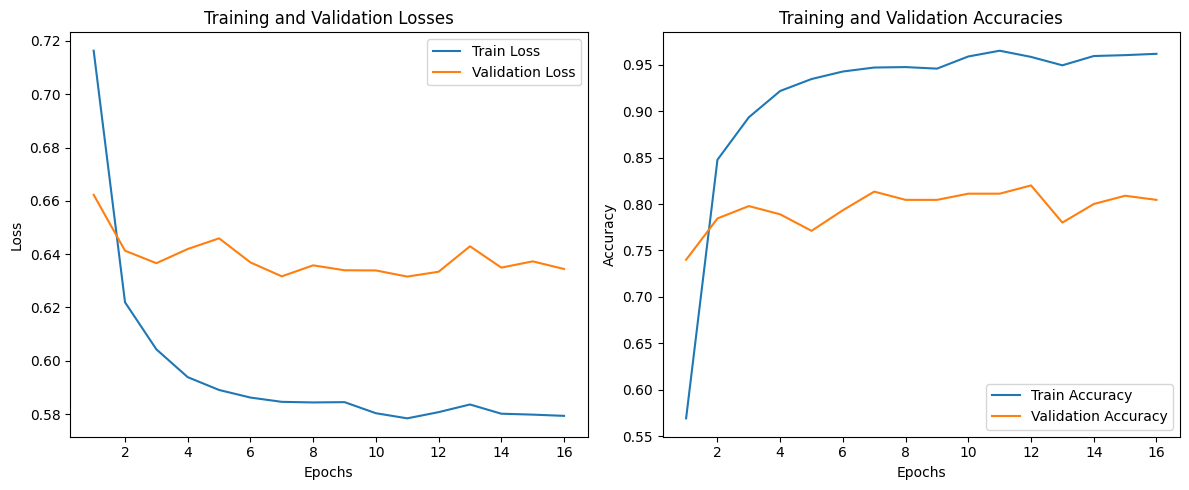

In [24]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, len(train_losses)+1), y=train_losses, label='Train Loss')
    sns.lineplot(x=range(1, len(val_losses)+1), y=val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')

    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, len(train_accuracies)+1), y=train_accuracies, label='Train Accuracy')
    sns.lineplot(x=range(1, len(val_accuracies)+1), y=val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracies')

    plt.tight_layout()
    plt.show()
    
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [29]:
test_loss, test_accuracy = test(model, test_loader, criterion, device)

if test_accuracy > 0.80:
    date_time = datetime.datetime.now().strftime("%Y-%m-%d_%H%M")
    file_name = f".\..\data\model\model_checkpoint_{date_time}_loss{test_loss:.3f}.pth"
    torch.save({
        'epoch' : best_epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : test_loss,
        }, file_name)
    print('Model saved')
    print(f"{test_loss = }, {test_accuracy = }")
else:
    print(f'Bad Model {test_loss = }, {test_accuracy = }')

Test: 100%|██████████| 29/29 [00:03<00:00,  7.94it/s, loss=0.567]


Model saved
test_loss = 0.6260161379287983, test_accuracy = 0.8177777777777778


In [30]:
# Finding Accuracy
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            outputs = torch.sigmoid(outputs)
            predictions.append(outputs)
            real_values.append(labels)
            
    y_pred = torch.cat(predictions).cpu()
    y_test = torch.cat(real_values).cpu()
    
    y_pred = torch.argmax(y_pred, axis=1).numpy()
    y_test = torch.argmax(y_test, axis=1).numpy()
    
    return y_pred, y_test

y_pred, y_test = get_predictions(model, test_loader)

Classification Report for BERT :
               precision    recall  f1-score   support

    negative       0.75      0.84      0.79       150
     neutral       0.85      0.81      0.83       150
    positive       0.86      0.81      0.83       150

    accuracy                           0.82       450
   macro avg       0.82      0.82      0.82       450
weighted avg       0.82      0.82      0.82       450



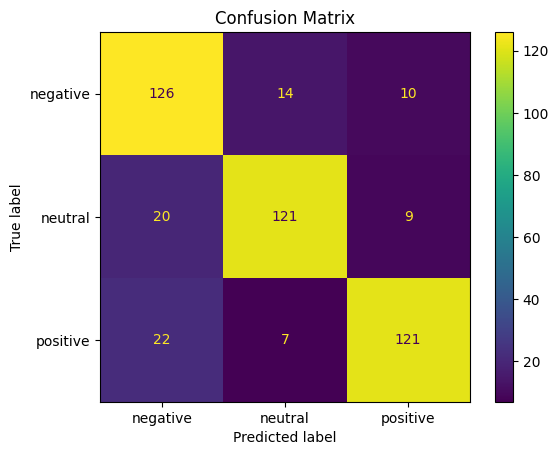

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


conf_mat = confusion_matrix(y_test, y_pred)
print('Classification Report for BERT :\n', classification_report(y_test, y_pred, target_names=one_hot.categories_[0].tolist()))
ConfusionMatrixDisplay(conf_mat, display_labels=one_hot.categories_[0].tolist()).plot()
plt.title('Confusion Matrix')
plt.grid(False)

Reff:

https://www.kaggle.com/code/harigovindasamy/sentiment-analysis-bert-79-accuracy 

https://www.kaggle.com/code/datafan07/disaster-tweets-nlp-eda-bert-with-transformers